# Compute the theoretically maximized expectation given $\theta_j$'s

Since $r_{I(t)}\sim{\rm Bern}(\theta_{I(t)})$ and all the $\theta_j$'s are already given, we can easily compute the maximized expectation of $\sum\limits_{t=1}^Nr_{I(t)}$.

$$
\mathbb{E}\left(\sum\limits_{t=1}^Nr_{I(t)}\right)=\sum\limits_{t=1}^N\mathbb{E}(r_{I(t)})=\sum\limits_{t=1}^N\theta_{I(t)}
$$

Now that the given values of $\theta_j$'s are $\theta_1=0.8,\theta_2=0.6,\theta_3=0.5$, in order to obtain the maximized expectation, it suffices to pull arm 1 each time. So the aggeragate rewards over $N$ times is $N*\theta_1=0.8N$.

Therefore the oracle value is $0.8N=4800$.

# Classical bandit algorithms

In this section, we will find out the performance of the given algorithms: $\epsilon$-greedy, UCB and Thompson sampling.

As for each algorithm, in terms of different parameters, there are three steps in total:

- Algorithm implementation.

- Compute the outcomes over 200 independent experiments.

- Regret analysis, including mean and variance of the gap between the algorithm outputs and the oracle value.

We use the given parameters $\theta_1=0.8,\theta_2=0.6,\theta_3=0.5$ to generate $r_{I(t)}$ at each time slot $t$.


In [51]:
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import scipy.stats as stats
import os
from PIL import Image
N = 6000
EPS = 200
prob = [0.8, 0.6, 0.5]


In [56]:
class Bandit1:
    def __init__(self):
        self.prob = np.array(prob)  # The true rate of reward of each arm
        self.count = np.zeros(3)
        self.est_values = np.zeros(3)

    def reward(self, arm):
        '''Generate the reward by Bernoulli trial'''
        return random.binomial(1, self.prob[arm])

    def e_greedy(self, epsilon):
        '''Determine whether to explore or exploit'''
        rand = random.random()
        if rand < epsilon:
            return random.randint(3)  # Exploration
        else:
            return np.argmax(self.est_values)  # Exploitation

    def UCB(self,c,t):
        '''Compute the comprehensive value of exploration and exploitation to determine which arm to choose'''
        EE_mix = np.array(self.est_values+c*np.sqrt(2*np.log(t+1)/self.count))
        return np.argmax(EE_mix)

    def update(self, arm, R):
        '''Update the number of being selected and the estimated reward of the arm'''
        self.count[arm] += 1
        self.est_values[arm] += (R-self.est_values[arm])/self.count[arm]


## $\epsilon$-greedy Algorithm


### Implementation


In [36]:
epsilon = [0.2, 0.4, 0.6, 0.8]
def experiment1(bandit, epsilon):
    sum = 0 # The aggreagte reward of a certain experiment
    tmp_cum_reward = [0] # The average cumulative reward at each time slot
    for t in range(N):
        arm = bandit.e_greedy(epsilon)
        reward = bandit.reward(arm)
        bandit.update(arm, reward)
        sum += reward
        tmp_cum_reward.append((t*tmp_cum_reward[t]+reward)/(t+1))
    return [sum, 4800-sum, np.array(tmp_cum_reward[1:])]


### Simulative Outcomes

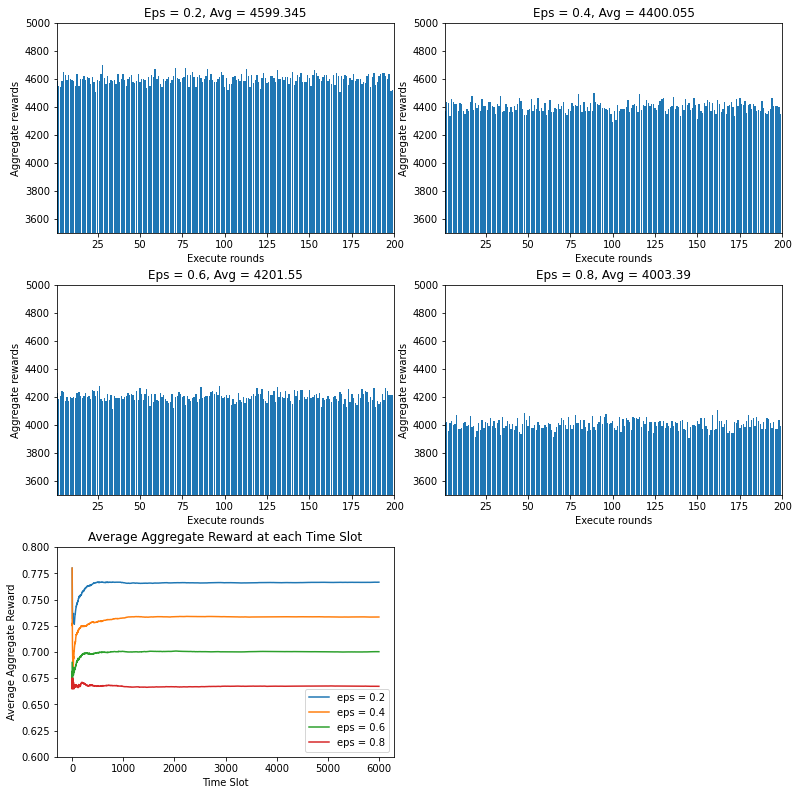

In [37]:
plt.figure(figsize(13, 13.5))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.15, hspace=0.25)
cum_reward = np.zeros((4, N))
for i, e in enumerate(epsilon):
    epm_reward = []  # The aggreagte reward of each experiment
    for times in range(EPS):
        bandit = Bandit1()
        outcome = experiment1(bandit, e)
        epm_reward.append(outcome[0])
        cum_reward[i] += outcome[2]
    epm_reward = np.array(epm_reward)
    avg = np.average(epm_reward)
    # Plot a bar chart to illustrate the aggregate reward of each experiment:
    x = np.arange(1, EPS+1, 1)
    y = epm_reward
    plt.subplot(3, 2, i+1)
    plt.bar(x, y)
    plt.xlabel("Execute rounds")
    plt.ylabel("Aggregate rewards")
    plt.title("Eps = {}, Avg = {}".format(e, avg))
    plt.xlim(1, 200)
    plt.ylim(3500, 5000)

# Plot the average aggregate reward at each time slot
cum_reward /= np.float(EPS)
plt.subplot(3, 2, 5)
plt.xlabel("Time Slot")
plt.ylabel("Average Aggregate Reward")
plt.title("Average Aggregate Reward at each Time Slot")
plt.plot(cum_reward[0], label="eps = 0.2")
plt.plot(cum_reward[1], label="eps = 0.4")
plt.plot(cum_reward[2], label="eps = 0.6")
plt.plot(cum_reward[3], label="eps = 0.8")
plt.ylim(0.6, 0.8)
plt.legend()
plt.show()


### Regret Analysis


In [22]:
for e in epsilon:
    regrets = []
    for times in range(EPS):
        bandit = Bandit1()
        outcome = experiment1(bandit, e)
        regrets.append(outcome[1])
    gap = np.array(regrets)
    # Compute the mean and variance of 200 regrets
    Mean = np.mean(gap)
    Var = np.var(gap)
    print("When epsilon = {}:".format(e))
    print("Mean = {} ".format(Mean))
    print("Var = {}\n".format(Var))


When epsilon = 0.2:
Mean = 202.465 
Var = 1329.538775

When epsilon = 0.4:
Mean = 400.28 
Var = 1370.7015999999996

When epsilon = 0.6:
Mean = 603.955 
Var = 1201.0829749999998

When epsilon = 0.8:
Mean = 799.3 
Var = 1439.17



## UCB Algorithm


### Implementation

In [38]:
C = [2, 6, 9]

def experiment2(bandit, c):
    sum = 0  # The aggreagte reward of a certain experiment
    tmp_cum_reward = [0]  # The average cumulative reward at each time slot
    for t in range(3):
        # Initialization
        arm = t
        reward = bandit.reward(arm)
        bandit.update(arm, reward)
        sum += reward
        tmp_cum_reward.append((t*tmp_cum_reward[t]+reward)/(t+1))
    for t in range(3, N):
        arm = bandit.UCB(c, t)
        reward = bandit.reward(arm)
        bandit.update(arm, reward)
        sum += reward
        tmp_cum_reward.append((t*tmp_cum_reward[t]+reward)/(t+1))
    return [sum, 4800-sum, np.array(tmp_cum_reward[1:])]


### Simulative Outcomes


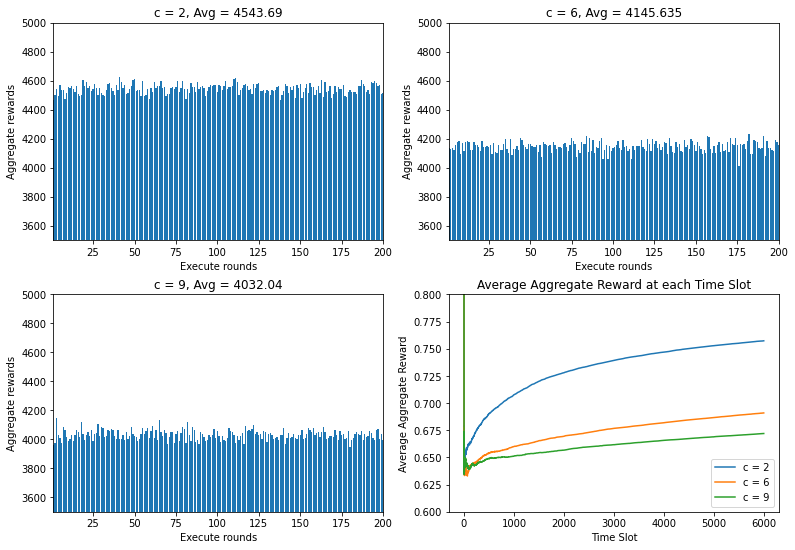

In [53]:
plt.figure(figsize=(13,9))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.25)
cum_reward = np.zeros((3, N))

for i,c in enumerate(C):
    epm_reward = []  # The aggregate reward of each experiment
    for times in range(EPS):
        bandit = Bandit1()
        outcome = experiment2(bandit, c)
        epm_reward.append(outcome[0])
        cum_reward[i] += outcome[2]
    epm_reward = np.array(epm_reward)
    avg = np.average(epm_reward)
    # Plot a bar chart to illustrate the aggregate reward of each experiment:
    x = np.arange(1, EPS+1, 1)
    y = epm_reward
    plt.subplot(2, 2, i+1)
    plt.bar(x, y)
    plt.xlabel("Execute rounds")
    plt.ylabel("Aggregate rewards")
    plt.title("c = {}, Avg = {}".format(c, avg))
    plt.xlim(1, 200)
    plt.ylim(3500, 5000)

# Plot the average aggregate reward of each time slot
cum_reward /= np.float(EPS)
plt.subplot(2, 2, 4)
plt.xlabel("Time Slot")
plt.ylabel("Average Aggregate Reward")
plt.title("Average Aggregate Reward at each Time Slot")
plt.plot(cum_reward[0], label="c = 2")
plt.plot(cum_reward[1], label="c = 6")
plt.plot(cum_reward[2], label="c = 9")
plt.ylim(0.6, 0.8)
plt.legend()
plt.show()


### Regret Analysis


In [54]:
for c in C:
    regrets = []
    for times in range(EPS):
        bandit = Bandit1()
        outcome = experiment2(bandit, c)
        regrets.append(outcome[1])
    gap = np.array(regrets)
    # Compute the mean and variance of 200 regrets
    Mean = np.mean(gap)
    Var = np.var(gap)
    print("When c = {}:".format(c))
    print("Mean = {} ".format(Mean))
    print("Var = {}\n".format(Var))


When c = 2:
Mean = 258.55 
Var = 1184.9475

When c = 6:
Mean = 662.0 
Var = 1166.33

When c = 9:
Mean = 773.965 
Var = 1113.153775



## Thompson Sampling Algorithm


### Implementation

In [61]:
Alpha = np.array([[1, 1, 1], [601, 401, 2]])
Beta = np.array([[1, 1, 1], [401, 601, 3]])

class Bandit2:
    def __init__(self, alpha, beta):
        self.prob = np.array(prob)  # The true rate of reward of each arm
        self.alpha = np.array(alpha)
        self.beta = np.array(beta)

    def reward(self, arm):
        '''Generate the reward by Bernoulli trial'''
        return random.binomial(1, self.prob[arm])

    def sample(self):
        '''Sample estimated rewards from Beta distributions'''
        est_values = random.beta(self.alpha, self.beta)
        return np.argmax(est_values)

    def update(self, arm, R):
        '''Update the number of being selected and the estimated reward of the arm'''
        self.alpha[arm] += R
        self.beta[arm] += 1-R

def experiment3(bandit):
    sum = 0  # The aggreagte reward of a certain experiment
    tmp_cum_reward = [0]  # The average cumulative reward at each time slot
    for t in range(N):
        arm = bandit.sample()
        reward = bandit.reward(arm)
        bandit.update(arm, reward)
        sum += reward
        tmp_cum_reward.append((t*tmp_cum_reward[t]+reward)/(t+1))
    return [sum, 4800-sum, np.array(tmp_cum_reward[1:])]


### Simulative Outcomes


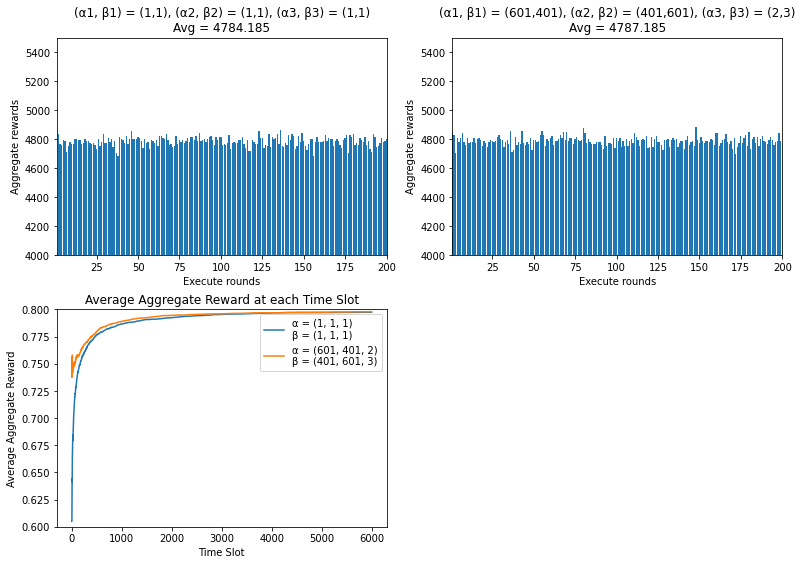

In [47]:
plt.figure(figsize=(13, 9))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.25)
cum_reward = np.zeros((2, N))

for i in range(2):
    epm_reward = []  # The aggregate reward of each experiment
    for times in range(EPS):
        alpha = Alpha[i].copy()
        beta = Beta[i].copy()
        bandit = Bandit2(alpha, beta)
        outcome = experiment3(bandit)
        epm_reward.append(outcome[0])
        cum_reward[i] += outcome[2]
    epm_reward = np.array(epm_reward)
    avg = np.average(epm_reward)
    # Plot a bar chart to illustrate the aggregate reward of each experiment:
    plt.subplot(2, 2, i+1)
    x = np.arange(1, EPS+1, 1)
    y = epm_reward
    plt.bar(x, y)
    plt.xlabel("Execute rounds")
    plt.ylabel("Aggregate rewards")
    plt.title("(α1, β1) = ({},{}), (α2, β2) = ({},{}), (α3, β3) = ({},{})\nAvg = {}".format(
        Alpha[i][0], Beta[i][0], Alpha[i][1], Beta[i][1], Alpha[i][2], Beta[i][2], avg))
    plt.xlim(1, 200)
    plt.ylim(4000, 5500)

# Plot the average aggregate reward of each time slot
cum_reward /= np.float(EPS)
plt.subplot(2, 2, 3)
plt.xlabel("Time Slot")
plt.ylabel("Average Aggregate Reward")
plt.title("Average Aggregate Reward at each Time Slot")
plt.plot(cum_reward[0], label="α = (1, 1, 1)\nβ = (1, 1, 1)")
plt.plot(cum_reward[1], label="α = (601, 401, 2)\nβ = (401, 601, 3)")
plt.ylim(0.6, 0.8)
plt.legend()
plt.show()


### Regret Analysis


In [64]:
for i in range(2):
    regrets = []
    for times in range(EPS):
        alpha = Alpha[i].copy()
        beta = Beta[i].copy()
        bandit = Bandit2(alpha, beta)
        outcome = experiment3(bandit)
        regrets.append(outcome[1])
    gap = np.array(regrets)
    # Compute the mean and variance of 200 regrets
    Mean = np.mean(gap)
    Var = np.var(gap)
    print("When (alpha_1, beta_1) = ({},{}), (alpha_2, beta_2) = ({},{}), (alpha_3, beta_3) = ({},{}):".format(
        Alpha[i][0], Beta[i][0], Alpha[i][1], Beta[i][1], Alpha[i][2], Beta[i][2]))
    print("Mean = {} ".format(Mean))
    print("Var = {}\n".format(Var))


When (alpha_1, beta_1) = (1,1), (alpha_2, beta_2) = (1,1), (alpha_3, beta_3) = (1,1):
Mean = 13.675 
Var = 867.499375

When (alpha_1, beta_1) = (601,401), (alpha_2, beta_2) = (401,601), (alpha_3, beta_3) = (2,3):
Mean = 14.855 
Var = 989.6039749999999



# Comparison of Different Algorithms


In this section, we compare the regrets of three algorithms and determine which is the best.


## Summary of Algorithm Performances

Here are some tables demonstrating the mean and variance of regrets over 200 experiments.


### $\epsilon$-greedy

| $\epsilon$ |    0.2    |   0.4    |    0.6    |    0.8    |
| :--------: | :-------: | :------: | :-------: | :-------: |
|    Mean    |  202.465   |  400.28  |  603.955  |  799.3   |
|  Variance  | 1329.53 | 1370.70 | 1201.08 | 1439.17 |

### UCB

|   $c$    |     2     |     6     |     9     |
| :------: | :-------: | :-------: | :-------: |
|   Mean   | 258.55  |  662.0  |  773.965  |
| Variance | 1184.94 | 1166.33 | 1113.15 |

### Thompson Sampling

| $(\alpha,\beta)$ | $(\alpha_1,\beta_1)=(1,1),(\alpha_2,\beta_2)=(1,1),(\alpha_3,\beta_3)=(1,1)$ | $(\alpha_1,\beta_1)=(601,401),(\alpha_2,\beta_2)=(401,601),(\alpha_3,\beta_3)=(2,3)$ |
| :--------------: | :--------------------------------------------------------------------------: | :----------------------------------------------------------------------------------: |
|       Mean       |                                    13.675|                                        14.855                                        |
|     Variance     |                                  867.49                                   |                                      989.60                                       |


## Analysis

We focus on both mean and variance of the regrets, because the accuracy and stability are the two most important evaluation indices of the performances of algorithms.


### Accuracy

Thompson sampling algorithm has the highest accuracy, with the mean of regret only around 13-15. The means of other two algorithms are both over 200, with more regrets as their hyperparameters increase.


### Stability

From Thompson sampling, to UCB, to $\epsilon$-greedy, the variance gradually increases, meaning that the stability gradually decreases. Therefore, Thompson sampling is relatively the most stable algorithm, while the other two algorithms are less stable.


## Conclusion

Comprehensively consider both accuracy and stability, Thompson sampling is the optimal algorithm of classic multi-armed bandit, since it is the most accurate and most stable.


# Discussion of the Impacts of Different Parameters


Since all the experiments are based on the already given parameters, we need to further explore the impacts of their respective parameters and find the optimal choices if possible.

**By the way, since the exploration-exploitation trade-off is highly correlated to the impacts of hyperparameters, my further understanding towards the trade-off problem will be included in either _Analysis_ or _Conclusion_ part, or both. Honestly, it is complicated to discuss it separately in another section.**

The general idea of exploration-exploitation trade-off is:

- Both exploration and exploitation have pros and cons, we need to find an appropriate ratio to determine how much should we explore and exploit, to maximize their advantages and minimize their disadvantages.

- As for exploration, sometimes the potentially optimal arm has not been observed, so appropriately exploring provides more chances to find the optimal arm. However, if the proportion of exploration is too much, our strategy approximately turns out to be randomization, so the potentially optimal arm may not be pulled many times. Exploration is similar to stake, because every time we decide to explore, there are two possible outcomes: either being closed to the potential optimality, or running into non-optimal arm and hence causing deadweight loss.

- As for exploitation, sometimes the locally optimal solution is exactly the globally optimal solution, so repeatedly pulling the locally optimal arm leads to optimal reward. However, sometimes the locally optimal solution is not the globally optimal solution, if we exploit too much, we may be trapped in the local optimality and miss the potential global optimality.

- The trade-off of exploration-exploitation, is exactly how to firstly find a local optimality, and then try to escape the bondage of local optimality and transit to global optimality.

More detailed comprehension of exploration-exploitation trade-off will be further discussed in the following part.

## $\epsilon$-greedy

### Find the Optimal $\epsilon$ by Simulation
We will apply different values of $\epsilon$ to the algorithm and try to find out which performs the best. For $\epsilon\in[0,1]$, we take $\epsilon=0.05k$, where $k=0,1,\cdots,20$, to compare the aggregate rewards over $6000$ time slots given different $\epsilon$'s.

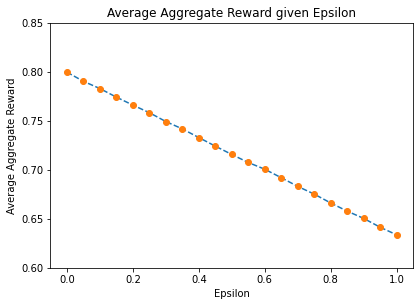

In [29]:
epsilon = [0.05*k for k in range(21)]
plt.figure(figsize(6.5, 4.5))
# The average reward at each time slot for different epsilons
agg_avg_reward = np.zeros((21, N))

for i in range(len(epsilon)):
    e = epsilon[i]
    for times in range(EPS):
        bandit = Bandit()
        outcome = experiment1(bandit, e)
        agg_avg_reward[i] += outcome[2]
# Compute the average cumulative average reward over 200 experiments:
agg_avg_reward /= np.float(EPS)

# Visualization:
x=np.array(epsilon)
y = agg_avg_reward[:, N-1]
plt.xlabel("Epsilon")
plt.ylabel("Average Aggregate Reward")
plt.title("Average Aggregate Reward given Epsilon")
plt.ylim(0.6, 0.85)
plt.plot(x,y,'--')
plt.plot(x, y, 'o')
plt.show()


### Analysis

By definition, $\epsilon$ is the probability of randomly choosing an arm to pull at each time slot, which is the process of exploration. In fact, it represents our consideration towards the trade-off of exploitation and exploration, since by simple greedy strategy we should pull the arm with the highest reward rate, but based on the limited samples, we cannot take it for granted that we must pull the temporarily best arm. It is also possible that randomly choosing another arm can have a higher possibility to earn a reward.

Based on the curves above, we know that $\epsilon=0$ is optimal, and the algorithm performs worse and worse while $\epsilon$ is increasing. That is to say, the more exploitation, the more rewards.

However, the result is inconsistent with our intuitive judgment, because obviously, exploring with a small probability can somehow decrease the uncertainty of locally optimal solution by trying to avoid repeatedly exploiting it. So we guess that the optimal parameter $\epsilon=0$ is only appropriate for THIS multi-armed bandit, with real rates of return where $\theta_1=0.8,\theta_2=0.6,\theta_3=0.5$.

Here is a more detailed explanation about the reason why $\epsilon=0$ is optimal:

With $\epsilon=0$, we should exploit the best arm at each time slot. We initialize $\hat{\theta_1}=\hat{\theta_2}=\hat{\theta_3}=0$, so by the operating mechanism of $np.argmax(\hat{\theta_j})$, when all the $\hat{\theta_j}$'s are the same, it will return the first index of identical elements by default, which is the first arm.

Since $\theta_1=0.8$ is the highest reward rate, the default outcome of the decision is exactly the best choice by coincidence. If the reward at this time is 1, $\hat{\theta_1}$ will be updated to be larger so we prefer to choose arm 1 at the following time slots. It does not matter if the reward is 0 because $\hat{\theta_1}$ will be updated to be 0, which comes back to the initial status without extra influence.

Since pulling arm 1 can get a reward more probably, during the whole process of pulling arms, in general $\hat{\theta_1}$ will be the largest estimation among three estimations, so we tend to pull arm 1 more than the other 2 arms and therefore the aggregate reward will be relatively maximized.

In conclusion, because of the coincidence that $np.argmax(\hat{\theta_j})$ will automatically return index 1 and pulling arm 1 has the highest probability to earn a reward, the greedy strategy relatively performs better than those with a small probability to randomly explore, so $\epsilon=0$ is optimal.

However, when the parameters $\theta_j$'s are different, the optimal $\epsilon$ should change.

In [15]:
def draw(pic_name):
    img = Image.open(os.path.join(pic_name + '.png'))
    plt.figure(dpi=140)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


For example, when $(\theta_1,\theta_2,\theta_3)=(0.5,0.6,0.8)$, a relatively general scenario, applying different $\epsilon$'s we have

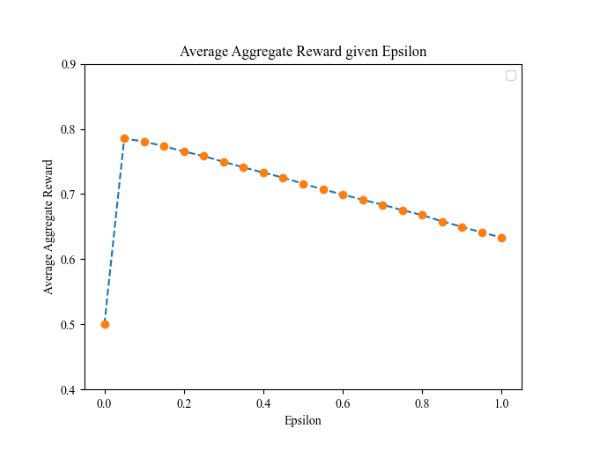

In [16]:
draw("Figure_1")

By the simulative outcome, the simple greedy strategy with $\epsilon=0$ is no longer appropriate and $\epsilon=0.05$ seems to be optimal.

More specifically, a closer examination of the variation of the average aggregate reward as $\epsilon$ varies near $0.05$ is shown below.

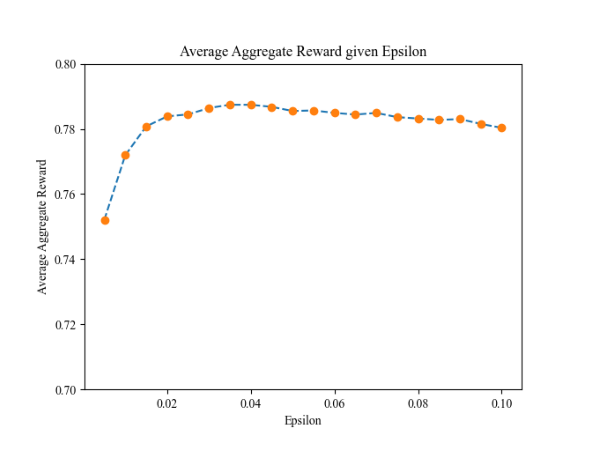

In [21]:
draw("Figure_2")

Therefore we can approximately determine that $\epsilon_0=0.035$ when $(\theta_1,\theta_2,\theta_3)=(0.5,0.6,0.8)$.

### Conclusion (Trade-off problem is discussed simultaneously)
By the discussion above, we know that for a multi-armed bandit, there must exist a single value $\epsilon_0$ that can optimize the $\epsilon$-greedy algorithm.

More detailed explanation about the impact of $\epsilon$ is stated below:

* When $\epsilon=0$, the $\epsilon$-greedy algorithm degrades into a simple greedy algorithm. Initially the first arm will be chosen and after that the highest estimated arm is chosen at each time slot. The potentially optimal arm may not be selected.

* When $\epsilon$ increases with $\epsilon<\epsilon_0$, the probability of exploration increases as well, so the optimal arm will be selected with increasing frequency and the non-optimal arm will be selected less. Therefore, obviously the aggregate reward keeps increasing.

* The increament of the aggregate reward continues until $\epsilon=\epsilon_0$, where the aggregate reward reaches its peak $R_{max}$ simultaneously. The point $(\epsilon_0,R_{max})$ represents the best solution and its outcome in the exploration-exploitation trade-off. That is to say, exploration with probability $\epsilon_0$ can maximize the aggregate reward of the multi-armed bandit.

* When $\epsilon_0<\epsilon<1$, the algorithm starts to shift in favor of exploration. Each arm will be randomly selected with increasing probability. As a result, the non-optimal arms begin to be chosen more frequently so the aggregate reward begins to fall.

* When $\epsilon=1$, randomization totally occupies all the decisions at each time slot, so exploration completely replaces exploitation. No matter what the estimaed reward of each arm is, they will be totally randomly selected, so we can no longer exploit the optimal arm. Therefore, the aggregate reward reaches relatively the lowest.

In conclusion, the selection of hyperparameter $\epsilon$ reflects the trade-off of exploitation and exploration: to what extend should we exploit the arm with the maximum estimated reward, or explore a random arm to make it more possible to find the potentially optimal arm?

As for this algorithm, the trade-off is simple, that is, we either choose to explore or to exploit, which is **binary opposition** relationship.

## UCB

### Find the Optimal $c$ by Simulation
We will apply different values of $c$, the confidence value, to the algorithm and try to find out which performs the best. Firstly, we take $c=2k$, where $k=0,1,\cdots,20$. The behaviour of the UCB algorithm, over a range of confidence values, is shown below.

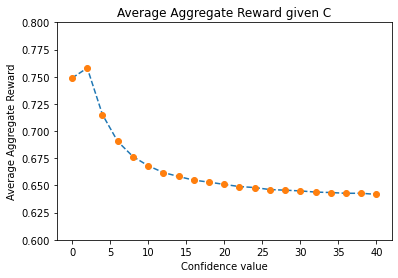

In [31]:
C = [2*k for k in range(21)]
plt.figure(figsize(6, 4))
# The average reward at each time slot for different epsilons
agg_avg_reward = np.zeros((21, N))

for i in range(len(C)):
    c=C[i]
    for times in range(EPS):
        bandit = Bandit()
        outcome = experiment2(bandit, c)
        agg_avg_reward[i] += outcome[2]
# Compute the average cumulative average reward over 200 experiments:
agg_avg_reward /= np.float(EPS)

# Visualization:
x = np.array(C)
y = agg_avg_reward[:, N-1]
plt.xlabel("Confidence value")
plt.ylabel("Average Aggregate Reward")
plt.title("Average Aggregate Reward given C")
plt.ylim(0.6, 0.8)
plt.plot(x, y, '--')
plt.plot(x, y, 'o')
plt.show()


Since the average aggregate reward drops dramatically when $c>2$, in order to better determine the optimal confidence value, we need to shrink the range of it to $[0.0,2.0]$ for a closer examination. As we take $c=0.1k$, where $k=0,1,\cdots,20$, the average aggregate reward as the confidence level is increased is shown below.

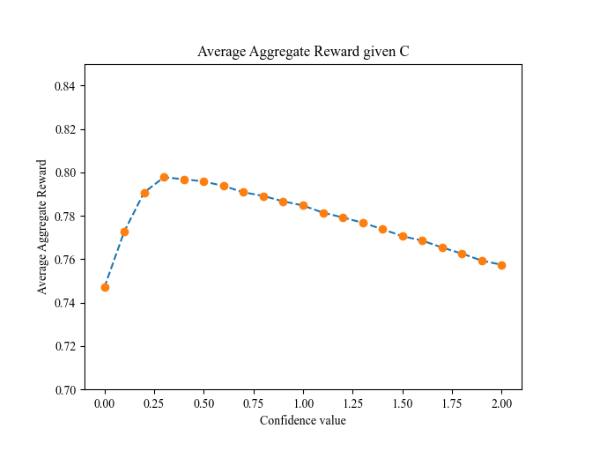

In [25]:
draw("Figure_3")

Here it can be seen that the average aggregate reward does increase, from having a confidence parameter of zero up to a value of approximately $c_0=0.3$, after which it drops gradually. So a small degree of exploration is required to get the best results.

### Analysis (Trade-off problem is discussed simultaneously)
The key decisive factor $\hat{\theta}(j)+c\cdot\sqrt{\frac{2\ln(t)}{\text{count}(j)}}$ is a combination of exploitation and exploration. The exploitative factor is $\hat{\theta}(j)$ and the explorative factor is $\sqrt{\frac{2\ln(t)}{\text{count}(j)}}$, controlled by the hyper-parameter $c$, which is called confidence value. The meaning of $\hat{\theta}(j)$ is obvious, so we mainly discuss the meaning of $\sqrt{\frac{2\ln(t)}{\text{count}(j)}}$.

Mathmatically, by Hoeffding bound, $\hat{\theta}(j)+\sqrt{\frac{2\ln(t)}{\text{count}(j)}}$ is the upper bound of $1-2t^{-4}$ confidence interval of $\theta_j$, and therefore the hyperparameter $c$ controls the size of confidence interval. The size of confidence interval also reflects our uncertainty towards the estimated rate of reward.

The concept of "uncertainty" is how confident we are in the estimated reward on a certain arm. If it is large, we may be confused about whether its temporary estimated reward is accurate, while if it is small, we can believe its accuracy to more extend. By the algorithm, the larger uncertainty an arm has, the larger probability it will be selected, since the upper bound of confidence interval is larger, indicating a higher probability that its potential rate of reward can be larger.

In fact, $\sqrt{\frac{2\ln(t)}{\text{count}(j)}}$ is a measurement of the uncertainty, and there are two deterministic factors, $\sqrt{\ln(t)}$ and $\sqrt{\text{count}(j)}$.

If an arm is not selected very often, then $\text{count}(j)$ will be small, consequently the uncertainty term will be large, making this arm more likely to be selected. Each time the arm is selected, $\text{count}(j)$ increases so we will be more confident about its estimated reward no matter whether its present output is 0 or 1, making it less likely to be selected.

Since as the time passes $\ln(t)$ increases as well, if an arm is not selected for a while, its uncertainty will increase because as the proportion of $\text{count}(j)$ over $t$ time slots becomes smaller, we are more unconfident about the estimated reward of the arm.

### Conclusion (Trade-off problem is discussed simultaneously)
Based the analysis above, we can know that $c$, the confidence value, controls the weight of uncertainty in the exploration-exploitation trade-off. The larger $c$ is, the more weight the exploration term has. By monotonicity, there must exist a single value $c_0$ that can optimize the UCB algorithm.

More detailed explanation about the impact of $\epsilon$ is stated below:

* When $c<c_0$, the selective decision is mainly determined by the estimaed values of arms. As the confidence value increases, uncertainty is considered more in the decision, so the arm with higher uncertainty is more likely to be selected so that its uncertainty can be sharply decreased, which makes it clearer for the estimated value. Also, the upper bound of confidence interval is appropriately enlarged, which gives a reasonable prediction of the true rate of reward, so the arm with maximal upper confidence bound can be regarded as the local optimum. Therefore, the aggregate reward increases simultaneously as $c$ increases.

* When $c=c_0$, the exploration-exploitation trade-off is highly optimized. Selections in this scenario can not only consider the estimated value to maximize the reward, but also consider the uncertainty to decrease it by selecting the corresponding arm. Also, the prediction of the upper bound is the most appropriate. Therefore the point $(c_0,R_{max})$ is at the peak of the reward curve.

* When $c>c_0$, the uncertainty is over-considered. Therefore, our strategy focuses more on how to reduce the uncertainty but relatively ignores the contributions of the estimated rewards, which can help us find the optimal arm. Therefore, the aggregate reward continuously decreases as $c$ increases.

The strategy of UCB algorithm is highly dependent on the combination of exploration and exploitation, i.e., the temporary upper confidence bound with proper enlargement $\hat{\theta}(j)+c\sqrt{\frac{2\ln(t)}{\text{count}(j)}}$, which is more like **cooperation and mutual benefits**.

In conclusion, the selection of hyperparameter $c$, the confidence value, represents the relative weight of exploration part and exploitation part. Proper selection can highly balance the contribution of either part, which maximizes the joint contribution.

## Thompson Sampling

### Detailed Variance of Parameters
It is difficult to give an intuitive explanation of the impacts of $\alpha_j$ and $\beta_j$, so we need draw several plots to show the changes of the PDFs of Beta distributions, where we can find out the sample strategy of TS.

In [ ]:
Alpha = np.array([1, 1, 1])
Beta = np.array([1, 1, 1])

class ARM:
    def __init__(self,p,id,alpha,beta):
        self.a=alpha[id]
        self.b=beta[id]
        self.p=p
        self.total=0
        self.success=0

    def reward(self):
        '''Generate the reward by Bernoulli trial'''
        return random.binomial(1,self.p)

    def sample(self):
        '''Generate the estimated reward through Beta distribution'''
        return random.beta(self.a,self.b)

    def update(self,R):
        '''Update the parameters of Beta distribution and the estimated reward of the arm'''
        self.total+=1
        self.a+=R
        self.b+=1-R
        self.success+=R

# Generate 3 arms:
arms=[ARM(prob[i],i,Alpha,Beta) for i in range(3)]

# A series of "milestones" where we output the PDFs when the time slot reaches each of them:
trails=[0,10,50,100,500,1000,3000,6000]

plt.figure(figsize(11.0, 10))
beta = stats.beta
x = np.linspace(0.0, 1.0, 200)

def draw():
    Arm_total = np.sum(np.array([arm.total for arm in arms]))

    colors = ["green", "red", "blue"]
    c_index = 0

    for i in range(3):
        c = colors[c_index]
        y = beta(arms[i].a, arms[i].b)
        p = plt.plot(x, y.pdf(x), lw=2, color=c,
                     label='{}/{}\n({},{})'.format(arms[i].success, arms[i].total, arms[i].a,arms[i].b))
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=0.2)
        plt.vlines(prob[i], 0, y.pdf(
            prob[i]), colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title("PDFs after {} Time Slots".format(Arm_total))
        plt.legend()
        plt.autoscale(tight=True)
        c_index += 1

def TS():
    trail=0 # The index of "milestones"
    for t in range(-1,N):
        # If the time slot reaches a "milestone", then plot the PDFs:
        if (t+1) == trails[trail]:
            plt.subplot(4, 2, trail+1)
            draw()
            trail += 1
            plt.autoscale(tight=True)

        # Generate the estimated rewards of 3 arms:
        est=[arm.sample() for arm in arms]

        # Find the arm with the maximum estimated reward:
        Arm_index=np.argmax(np.array(est))

        # Generate the reward and update its parameters:
        reward=arms[Arm_index].reward()
        arms[Arm_index].update(reward)

    plt.tight_layout()


Take $(\alpha_1,\beta_1)=(1,1),(\alpha_2,\beta_2)=(1,1),(\alpha_3,\beta_3)=(1,1)$ for example 1, where three arms respectively have true probabilities 0.8(green), 0.6(red) and 0.5(blue):

(Explanation of the legend:
Each colored line corresponds two lines of numbers. As for the first line, the format $K/N$ means that the arm is selected for $N$ times in total and the number of reward id $K$. As for the second line, the format $(\alpha,\beta$) means that the present parameters with respect to Beta distribution of the arm are $\alpha$ and $\beta$.)

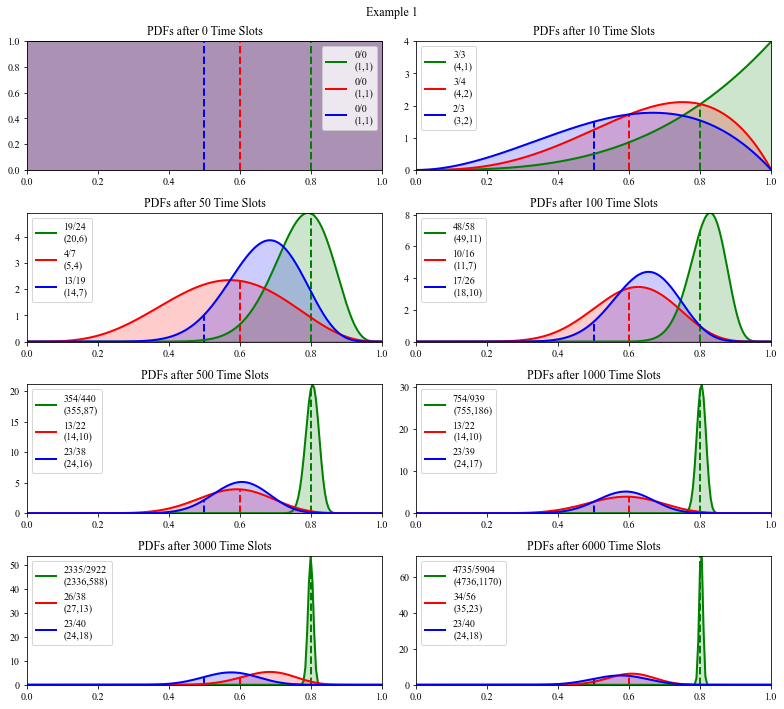

In [3]:
plt.suptitle("Example 1")
TS()

### Analysis (Trade-off problem is discussed simultaneously)

Note that for a continuous r.v. $X\sim{\rm Beta}(\alpha,\beta)$,
$$
E(X)=\frac{\alpha}{\alpha+\beta},{\rm Var}(X)=\frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$$
$$
\frac{\partial}{\partial\alpha}{\rm Var}(X)<0,\frac{\partial}{\partial\beta}{\rm Var}(X)<0
$$
Since $\alpha,\beta$ will be accumulated by the rewards as time goes by, the variance will become smaller and smaller, and the PDF will gradually become more and more slender unimodal functions, like the green curve shown above.

Meanwhile, as a certain arm has been selected for many times, the peak of its PDF will continuously converge to the real probability. By the plot above, we know that as long as the arm with the largest reward rate, denoted by $I$, becomes the majority, it will continuously be the majority afterwards. Therefore, for most of the trails, we will select arm $I$, which is extremely similar to the scenario of finding the oracle value. That is why Thompson Sampling algorithm is highly accurate.

That is to say, the whole process is another way to consider the exploration-exploitation trade-off, totally different from the former two algorithms. Essencially, Thompson sampling picks an arm randomly according to its probability to be the best, so here is an efficient strategy to simultaneously fully consider exploration and exploitation.

As for exploration, since the estimated reward is picked from a beta distribution through randomization, it provides chances for the potentially best arm to be chosen, like the process from Pic 3 to Pic 4 (in the figure above) in terms of the green curve. Besides, arms with almost no chance to be the best are almost never chosen to avoid spending time on useless exploration.

As for exploitation, it seems to be obvious. Consider the PDFs of three arms, those with high probabilities to be the best are chosen most of the time, so we can quickly lock in the best arm and keep selecting it till the end, which can highly maximize the aggregate reward.

The real reason why Thompson sampling performs extremely well is that since sampling from real distribution is always more accurate than estimation, the selected arm is highly consistent with the optimal arm. Therefore, the optimal arm can dominate all selections and the aggregate reward can be very large.

### Conclusion

We firstly discuss the common influence of $\alpha$ and $\beta$:

If $\alpha$ and $\beta$ are relatively small, like Ex.1, three arms have similar probabilities to be selected, so the optimal arm can be observed to be outstanding due to its high reward rate. In this scenario, the optimal arm can always be observed, and the aggregate reward is stable but no too closed to the oracle value.

If $\alpha$ and $\beta$ are both large, by the formula of variance, the variance will be very small so exploitation dominates all strategies and exploration seems to be a small probability event. Besides, since $E=\frac{\alpha}{\alpha+\beta}$, the PDF curve is tightly restricted near the value of expectation, so the scope for randomization is greatly limited. Therefore, whether we can get a perfect aggregate reward highly depends on whether we are lucky. That is to say, if the arm with maximum expectation is indeed the optimal arm, then the algorithm performs extremely well and even exceeds the oracle value if fortunate, see example 2. If not, the non-optimal arm will be selected over and over again so the aggregate reward is relatively small, see example 3. Even if there is intersection between green and red, the arm corresponding to green is selected with extreme small probability (only twice out of the first 500 time slots).

If some pairs are large and some are small, the aggregate reward also depends on luck. Although scenarios are too various to be detailedly discussed, we can generalize some general rules (denote the optimal arm by $I$): As long as $(\alpha_I,\beta_I)$ are large and $E(I)$ is also relatively large or close to its real reward rate, or $(\alpha_I,\beta_I)$ are relatively small, it still has high probability to be selected and hence the aggregate reward is close to the oracle value. However, if $(\alpha_I,\beta_I)$ are large but $E(I)$ is relatively small, the algorithm is more intended to select other arms and hence the aggregate reward is not perfect any more.

Example 2: $(\alpha_1,\beta_1)=(801,201),(\alpha_2,\beta_2)=(401,601),(\alpha_3,\beta_3)=(601,401)$.

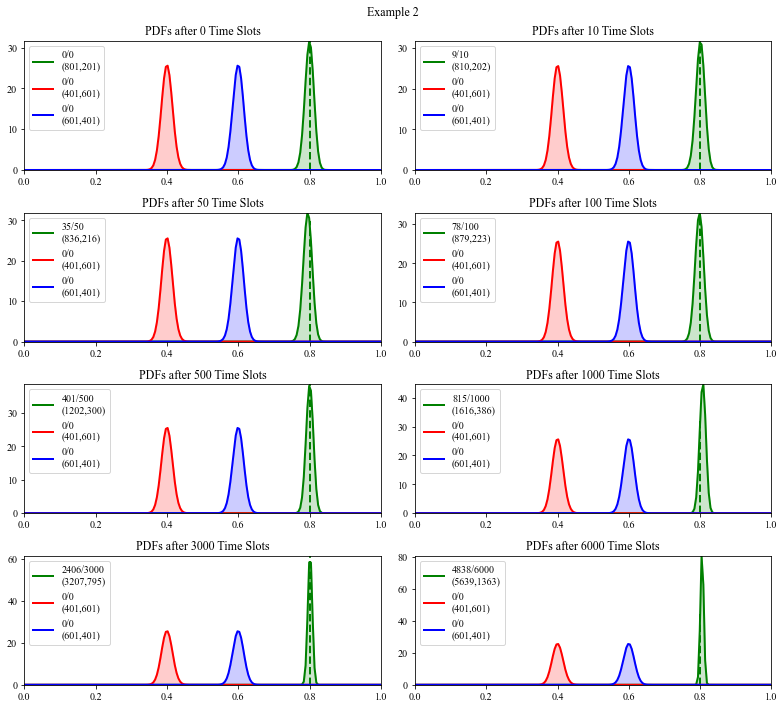

In [4]:
Alpha = np.array([801, 401, 601])
Beta = np.array([201, 601, 401])
arms = [ARM(prob[i], i, Alpha, Beta) for i in range(3)]
plt.suptitle("Example 2")
TS()


Example 3: $(\alpha_1,\beta_1)=(361,631),(\alpha_2,\beta_2)=(401,601),(\alpha_3,\beta_3)=(201,801)$.

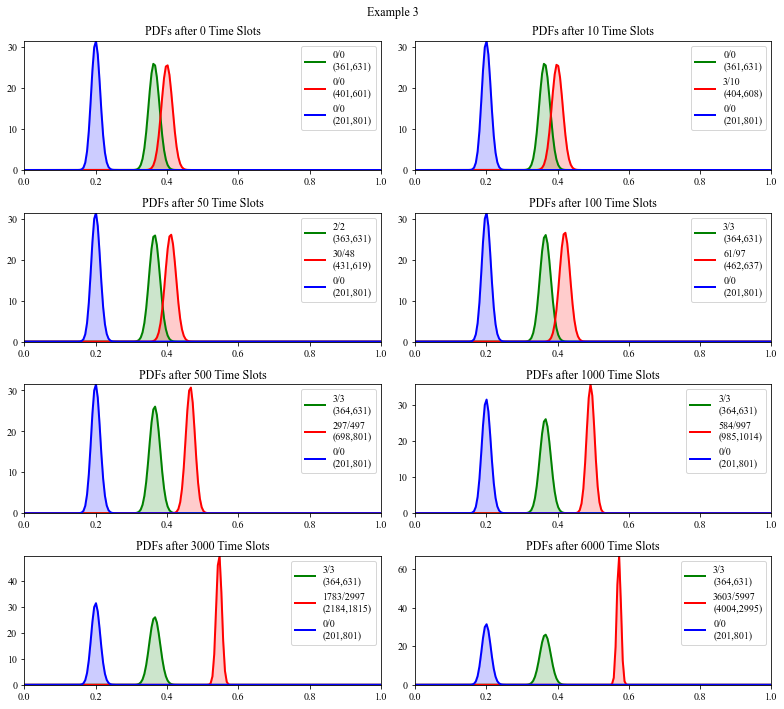

In [8]:
Alpha = np.array([361, 401, 201])
Beta = np.array([631, 601, 801])
arms = [ARM(prob[i], i, Alpha, Beta) for i in range(3)]
plt.suptitle("Example 3")
TS()


Then we discuss $\alpha$ and $\beta$ separately.

For fixed $\beta$, the larger $\alpha$ is, the larger the expectation is and the smaller the variance is, so the scope of exploration is already small. As shown in example 4, if $\alpha$ is relatively too large, it is difficult to distinguish which arm to choose initially so the probability of an arm being chosen is evenly distributed and therefore the non-optimal arms will be selected more, leading to less aggregate reward. However, if $\alpha$ is not too large, like $(\alpha_1,\alpha_2,\alpha_3)=(70,50,60)$, the variances are not too small as well so we can easily find the optimal arm, see example 5.

Example 4: $(\alpha_1,\beta_1)=(700,2),(\alpha_2,\beta_2)=(500,2),(\alpha_3,\beta_3)=(600,2)$.

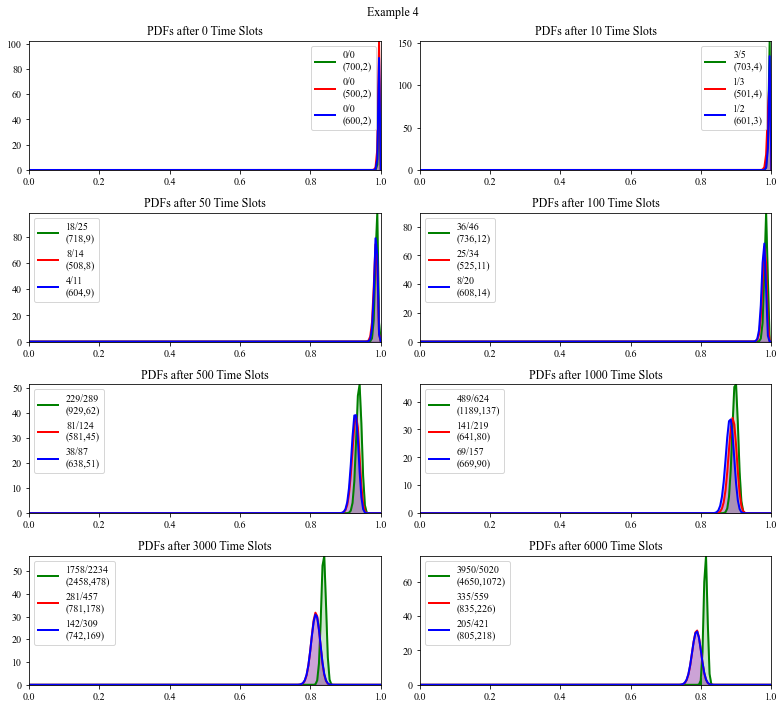

In [11]:
Alpha = np.array([700, 500, 600])
Beta = np.array([2, 2, 2])
arms = [ARM(prob[i], i, Alpha, Beta) for i in range(3)]
plt.suptitle("Example 4")
TS()


Example 5: $(\alpha_1,\beta_1)=(70,2),(\alpha_2,\beta_2)=(50,2),(\alpha_3,\beta_3)=(60,2)$.

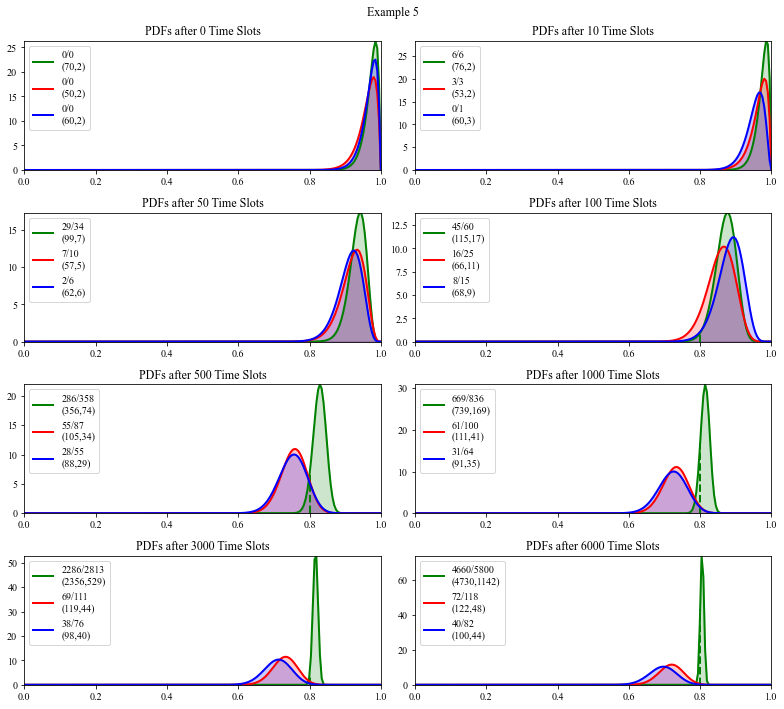

In [12]:
Alpha = np.array([70, 50, 60])
Beta = np.array([2, 2, 2])
arms = [ARM(prob[i], i, Alpha, Beta) for i in range(3)]
plt.suptitle("Example 5")
TS()


For fixed $\alpha$, the larger $\beta$ is, the smaller the expectation and variance is. If $\beta$ is not too large, like example 6, we can easily distinguish the optimal arm even if its expectation is smaller and then repeatedly select it so that the aggregate reward is perfect. However, if $\beta$ is large, since the variances are very small, whether the optimal arm can dominate all selections depends on whether its expectation is not the minimum. If $E(I)$ is the minimum, other non-optimal arms will be selected more and the aggregate reward is not perfect, see example 7.

Example 6: $(\alpha_1,\beta_1)=(2,70),(\alpha_2,\beta_2)=(2,60),(\alpha_3,\beta_3)=(2,60)$.

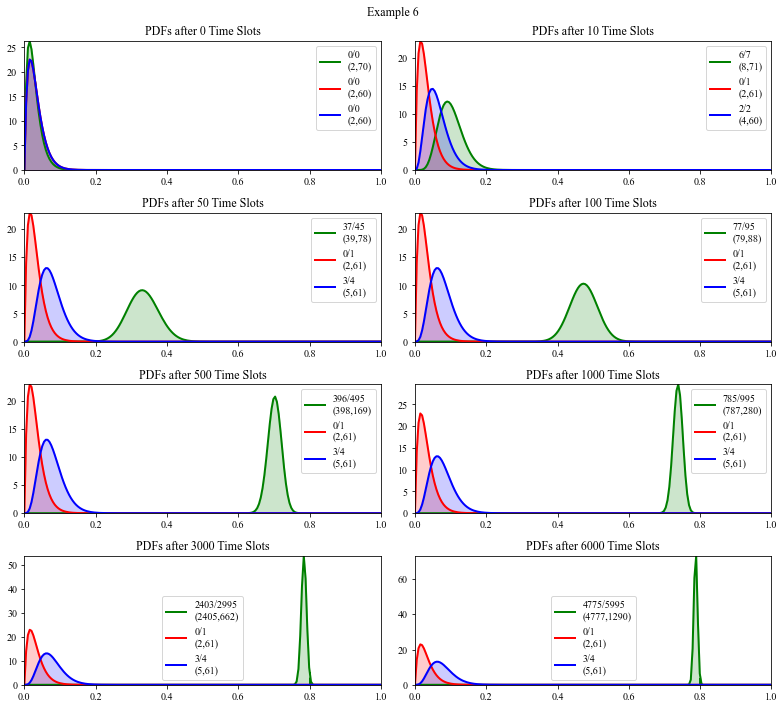

In [13]:
Alpha = np.array([2, 2, 2])
Beta = np.array([70, 60, 60])

arms = [ARM(prob[i], i, Alpha, Beta) for i in range(3)]
plt.suptitle("Example 6")
TS()


Example 7: $(\alpha_1,\beta_1)=(2,700),(\alpha_2,\beta_2)=(2,600),(\alpha_3,\beta_3)=(2,600)$.

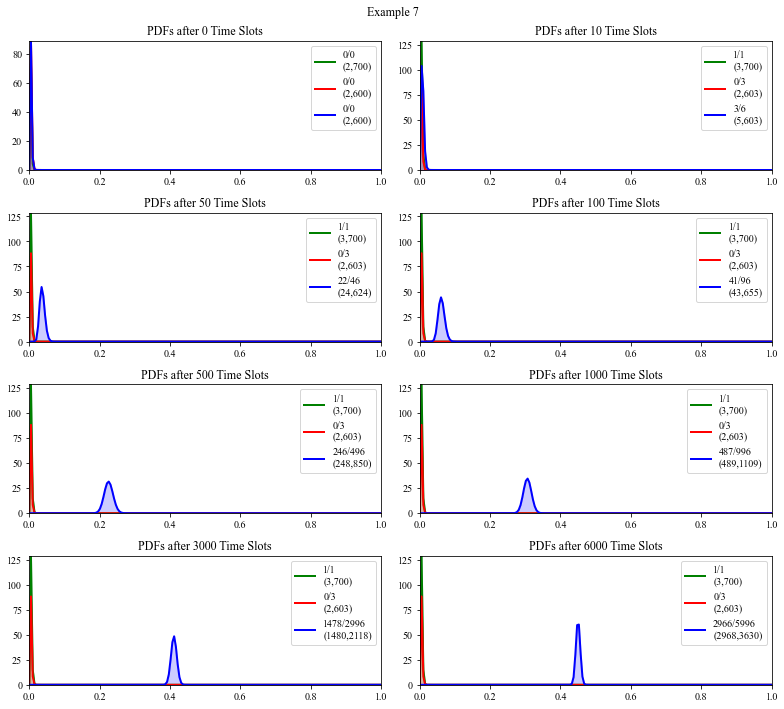

In [18]:
Alpha = np.array([2, 2, 2])
Beta = np.array([700, 600, 600])

arms = [ARM(prob[i], i, Alpha, Beta) for i in range(3)]
plt.suptitle("Example 7")
TS()


# Multi-armed Bandit with Dependent Arms

## Problem Formulation
Suppose that a mysterious fixed real parameter $\lambda\in(0,1)$ is hidden in the bandit, controlling the mean rewards of arms. That is, if we pull arm $I(t)\in\{1,2,3\}$ at time slot $t$ and get a reward $r_{I(t)}$, $r_{I(t)}$ is a r.v. satisfying Bernoulli distribution with mean $\theta_{I(t)}(\lambda)$, i.e.,
$$
r_{I(t)}=\begin{cases}
1,&w.p.\ \theta_{I(t)}(\lambda)\\
0,&w.p.\ 1-\theta_{I(t)}(\lambda)
\end{cases}
$$
where $\theta_{I(t)}(\lambda)$ is a funciton of $\lambda$ and $\theta_{I(t)}(\lambda)$ is fixed if $\lambda$ is given.

Suppose that $\lambda$ is unknown but the functions $\{\theta_1(\lambda),\theta_2(\lambda),\theta_3(\lambda)\}:\lambda\to\mathbb{R}$ are known to the player, i.e., for each given parameter $\lambda$, $\theta_k(\lambda)$ can be uniquely determined so we can draw its function plot over domain $(0,1)$.

Since $\lambda$ is unknown to us, we can use a continuous random variable $X\sim{\rm Beta}(a,b)$ to estimate $\lambda$, where $a,b$ are known positive constants. Therefore, the outcomes of three arms are no longer independent, but they are conditionally independent given $X=\lambda$.

## Problem Analysis
There are two steps of vital importance:

- Determine a reasonable condifence interval of $\lambda$ in which the true parameter $\lambda^*$ lies with high confidence.

- In the confidence interval of $\lambda$, determine which arms can be potentially selected, i.e., we should ignore those arms with relatively low rate of reward, and only determine which to select in a great arm set.

Since $\lambda\in(0,1)$ and rewards satisfy Bernoulli distributions given $X=\lambda$, it is natural to consider Beta-Binomial conjugacy to update the posterior distribution of $X$. However, by mathematical derivation, since the expectation of reward is a function $\theta(\lambda)$ rather than $\lambda$, the posterior distribution is no longer a beta distribution, so we cannnot depend on statistical conjugacy to approximate the true parameter.

## Algorithm Design
The new algorithm with respect to dependent arms is called UCB-DE.

### Determine Confidence Interval of $\lambda$
Before finding confidence interval, we should determine which arm should be used as standard. Apply the idea of exploitation, generally the arm with the most frequent selections is relatively the optimal arm. Denote its index by $I^{opt}$, $I^{opt}=\mathop{\arg\max}\limits_{i\in\{1,2,3\}}n_i$, where $n_i$ is the number of selections of arm $i$ until time slot $t$. We also get its estimated rate of reward $\hat{\theta}({I^{opt}})$.

Based on $I^{opt}$, by Hoeffding Bound, $\forall\epsilon>0$,
$$
P(|\theta_{I^{opt}}(\lambda)-\hat{\theta}({I^{opt}})|\geqslant\epsilon)=2e^{-2n_{I^{opt}}\epsilon^2}
$$
Let $\delta=2e^{-2n_{I^{opt}}\epsilon^2}$ we have $\epsilon=\sqrt{\frac{\ln(2/\delta)}{2n_{I^{opt}}}}$. Take $\delta=2t^{-4}$ we have $\epsilon=\sqrt{\frac{2\ln(t)}{n_{I^{opt}}}}$, the $1-\delta$ confidence interval of $\theta_{I^{opt}}(\lambda)$ is
$$\left[\hat{\theta}({I^{opt}})-\sqrt{\frac{2\ln(t)}{n_{I^{opt}}}},\hat{\theta}({I^{opt}})+\sqrt{\frac{2\ln(t)}{n_{I^{opt}}}}\right]$$

Therefore, the confidence interval of $\lambda$, denoted by $\Lambda$, is
$$
\Lambda=\left\{\lambda:|\theta_{I^{opt}}(\lambda)-\hat{\theta}({I^{opt}})|\leqslant\sqrt{\frac{2\ln(t)}{n_{I^{opt}}}}\right\}
$$

### Filter Competitive Arms
We define a competitive set of arms, where arm $j$ in the set satisfying $\exists\lambda\in\Lambda$ s.t. $\theta_j(\lambda)=\max\limits_{i\in\{1,2,3\}}\theta_i(\lambda)$. Accordingly, those that should be ignored, whose index is $k$ for example, satisfies $\forall\lambda\in\Lambda,\theta_j(\lambda)<\max\limits_{i\in\{1,2,3\}}\theta_i(\lambda)$. That is, whatever $\lambda$ is, selecting these arms must be non-optimal because there already exists an optimal arm to replace them. After filtering we obtain a competitive set, denoted by $\mathcal{C}$.

### Apply UCB Algorithm Process
We only apply classical UCB algorithm process to $\mathcal{C}$, the set of "candidates". At each time slot $t$, we select the arm, denoted by $I(t)$, in $\mathcal{C}$ with maximum upper confidence bound $\hat{\theta}(j)+c\sqrt{\frac{2\ln(t)}{n_j}}$, where $c$ is a positive constant with a default value of 1. After that, pull the selected arm and update both $n_j$ and $\hat{\theta}(j)$.

The pseudocode is shown below, explaining more detailed algorithm procedure.

# Multi-armed Bandit with Constraints

## Problem Formulation
Suppose that all arms are independent with each other, but pulling any arm will generate a fixed cost and the budget we have is limited.

Denote $c_i$ as the fixed cost of the $i$th arm, which are known to us, and $W$ as the total budget we have initially. At each time slot, denoted by $t$, we denote $W_t$ as the residual budget at time $t$.

We want to maximize the aggregate reward without exceeding the limited budget. That is, we need to maximize $\sum\limits_{i=1}^3n_i\hat{\theta}_i$ and satisfy $\sum\limits_{i=1}^3n_ic_i\leqslant W_t$ at the same time, where $n_i$ is the number of how many time that arm $i$ is pulled until time slot $t$.

## Problem Analysis
The problem scenario seems to be very similar to a classical model we have learnt: Knapsack problem! That is because, consider 3 categories of objects with unlimited items, where each item belonging to the $j$th category weighs $c_j$, whose value is a random variable satisfying ${\rm Bern}(\theta_j)$. The volumn of the knapsack is $W$, we want to maximize the aggregate value without exceeding the volumn of knapsack. This is an unbounded knapsack problem, which is very similar to the original problem. The unbounded knapsack problem with random reward can be solved by stochastic dynamic programming.

However, since we do not know the exact values of $\theta_j$'s, they have to be estimated parallel to pulling arms. Therefore we cannot apply stochastic dynamic programming to solve the original problem.

Fortunately, an optimal approximation to unbounded knapsack problem is considering fraction, i.e., suppose that the estimated rate of reward of arm $j$ is $\hat{\theta}_j$, we turn to consider $\frac{\hat{\theta}_j}{c_j}$ in UCB algorithm to determine which arm to choose at each time slot. The fraction reflects the value density of an arm, i.e. how much value per unit cost contains. Considering the arm with maximum value density is a excellent way to find optimal strategy.

## Algorithm Design
We propose a new algorithm with respect to the problem with constriants, named UCB-LB, to solve the problem with finite budget and fixed arm costs.

The general framework of UCB-LB algorithm is very similar to UCB algorithm, but at each time slot $t$, we need to construct a set $\mathcal{S}=\{i:c_i\leqslant W_t\}$, where our dicision over time slot $t$ must come from $\mathcal{S}$. Then, denote the selected arm by $I(t)$,
$$
I(t)=\mathop{\arg\max}\limits_{i\in\mathcal{S}}\left(\frac{\hat{\theta}_i+C\sqrt{\frac{2\ln(t)}{n_i}}}{c_i}\right)
$$
where $C$ is confidence value, which is a hyperparameter.

Like UCB algorithm, $\hat{\theta}_i+C\sqrt{\frac{2\ln(t)}{n_i}}$ is the upper bound of confidence interval. Combined with the denominator $c_i$, the fraction shows the upper bound of confidence interval in density sense.

After selecting the arm, in spite of updating $\hat\theta_{I(t)}$ and $n_{I(t)}$, we need to update the residual budget at time slot $t+1$, which is $W_{t+1}=W_t-c_{I(t)}$.

As for initialization, all three arms are pulled exactly once separately as what UCB does, but not in random order. We prefer to pulling the arms by "smaller cost, higher priority" strategy, i.e., the smaller the cost of any arm is, we tend to pull it with higher priority. Consider the limited budget, such greedy strategy can ensure that the initial three steps can get relatively more rewards to some extent.

The pseudocode is shown below, explaining more detailed algorithm procedure.